In [9]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
# import gymnasium as gym
import gym

In [10]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [11]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, n_actions),
            nn.Softmax(dim=0)
        )
    
    def forward(self, X):
        return self.model(X)
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [12]:
# Memory
# Stores results from the networks, instead of calculating the operations again from states, etc.
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)
        

In [13]:
env = gym.make("CartPole-v1")

c:\Users\aaron\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\aaron\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [14]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99
memory = Memory()
max_steps = 200

In [15]:
# train function
def train(memory, q_val):
    values = torch.stack(memory.values)
    q_vals = np.zeros((len(memory), 1))
    
    # target values are calculated backward
    # it's super important to handle correctly done states,
    # for those cases we want our to target to be equal to the reward only
    for i, (_, _, reward, done) in enumerate(memory.reversed()):
        q_val = reward + gamma*q_val*(1.0-done)
        q_vals[len(memory)-1 - i] = q_val # store values from the end to the beginning
        
    advantage = torch.Tensor(q_vals) - values
    
    critic_loss = advantage.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()
    
    actor_loss = (-torch.stack(memory.log_probs)*advantage.detach()).mean()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

In [26]:
episode_rewards = []

for i in range(150):
    done = False
    total_reward = 0
    state = env.reset()
    steps = 0

    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        
        total_reward += reward
        steps += 1
        memory.add(dist.log_prob(action), critic(t(state)), reward, done)
        
        state = next_state
        
        # train if done or num steps > max_steps
        if done or (steps % max_steps == 0):
            last_q_val = critic(t(next_state)).detach().data.numpy()
            train(memory, last_q_val)
            memory.clear()
            
    episode_rewards.append(total_reward)

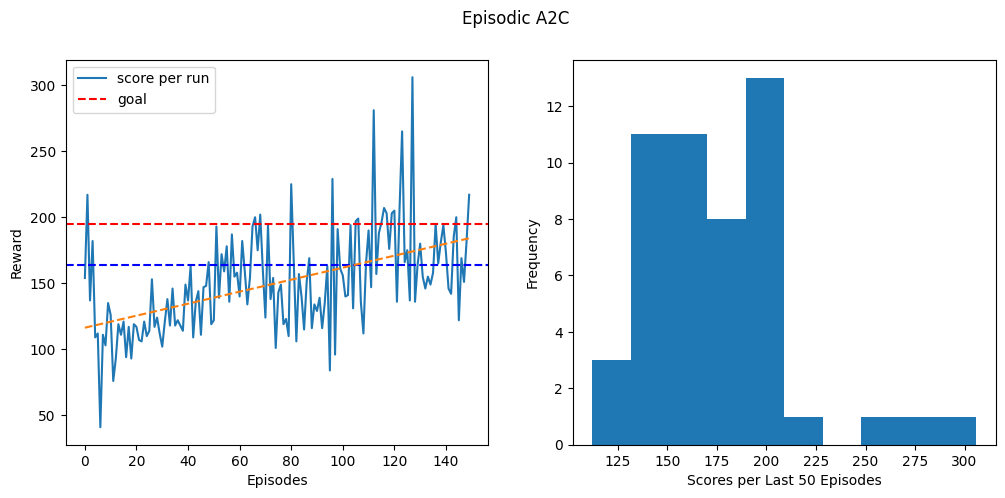

In [27]:
def plot_res(values, title=''):
    # clear_output(wait=True)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red', ls='--', label='goal')
    ax[0].axhline(np.mean(values[-100:]), c='blue', ls='--')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x, p(x), "--", label='trend')
    except:
        pass
    ax[1].hist(values[-50:])
    # ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    # ax[1].legend()
    plt.show()
plot_res(episode_rewards, title='Episodic A2C')